## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) database, which was built from the recordings of study participants who carried a smartphone with an embedded inertial sensor while performing activities of daily living (ADL). The objective is to classify the activities the participants performed into one of the six following categories: walking, walking upstairs, walking downstairs, sitting, standing, and laying.

The following information is provided for each record in the dataset:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
*   Triaxial Angular velocity from the gyroscope
*   A 561-feature vector with time and frequency domain variables
*   The activity label

More information about the features are available on the website linked above.

## Question 1

Import the data and do the following:

*   Examine the data types--there are many columns, so it might be wise to use value counts.
*   Determine if the floating point values need to be scaled.
*   Determine the breakdown of each activity.
*   Encode the activity label as an integer.


# Importing Libraries

supress warning notification

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate,  cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time
from time import time
from sklearn.metrics import roc_auc_score, make_scorer
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [3]:
data = pd.read_csv('Human_Activity_Recognition_Using_Smartphones_Data.csv')

In [4]:
data.columns 

Index(['Unnamed: 0', 'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y',
       'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y',
       'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y',
       'tBodyAcc-mad()-Z',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=563)

In [5]:
data.dtypes.value_counts()

float64    561
int64        1
object       1
Name: count, dtype: int64

In [6]:
data.shape

(10299, 563)

In [7]:
data['Activity'].value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

# Exploratory Data Analysis

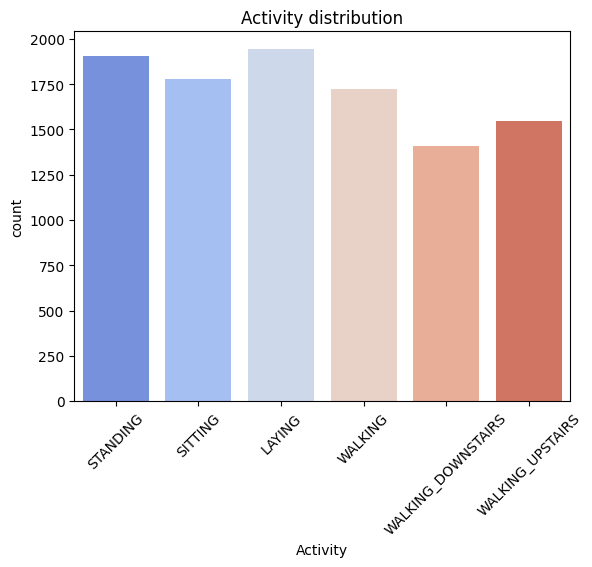

In [8]:
# Plot Target variable distribution
sns.countplot(x='Activity', data=data, palette="coolwarm")
plt.title('Activity distribution')
plt.xticks(rotation=45)
plt.show()

In [28]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

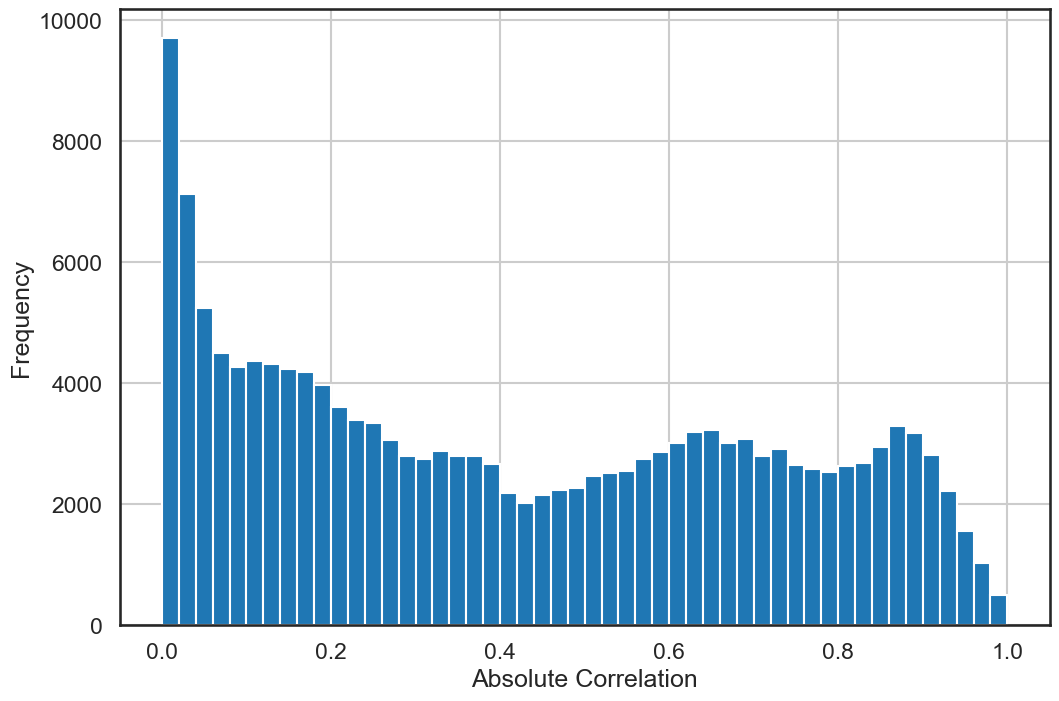

In [29]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

## LabelEncoder
Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.\
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)


# Data Splitting and Scaling

## StratifiedShuffleSplit

*   Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
*   Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.

In [10]:
#spliting the data
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


# Training and Evaluating

In [11]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging Classifier": BaggingClassifier(),
    "MLP Classifier": MLPClassifier(max_iter=500)
}

In [12]:
# Define the metrics we want to evaluate for each model
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = []

# Train and evaluate each model using K-fold cross-validation
for name, model in models.items():
    start_time = time()  # Start the timer
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    end_time = time()  # End the timer
    
    # Compute the average of each metric across the folds
    accuracy = np.mean(scores['test_accuracy'])
    precision = np.mean(scores['test_precision'])
    recall = np.mean(scores['test_recall'])
    f1 = np.mean(scores['test_f1'])
    auc = np.mean(scores['test_roc_auc'])  # Correctly using the AUC variable
    elapsed_time = end_time - start_time  # Time taken to run the model
    
    # Store the results in the list
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "AUC": auc,  # Corrected variable name
        "Time (s)": elapsed_time
    })

    print(f"{name} completed in {elapsed_time:.4f} seconds.")

Logistic Regression completed in 5.9343 seconds.
Random Forest completed in 63.2194 seconds.
SVM completed in 602.1148 seconds.
Decision Tree completed in 26.8096 seconds.
KNN completed in 2.2373 seconds.
Naive Bayes completed in 1.2393 seconds.
AdaBoost completed in 141.9080 seconds.
Bagging Classifier completed in 189.3640 seconds.
MLP Classifier completed in 33.4434 seconds.


# Display Detailed Performance Results

In [14]:
# Convert results into a DataFrame for better visualization
results_df = pd.DataFrame(results)

In [15]:
# Sort by Accuracy (or any other metric of choice)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

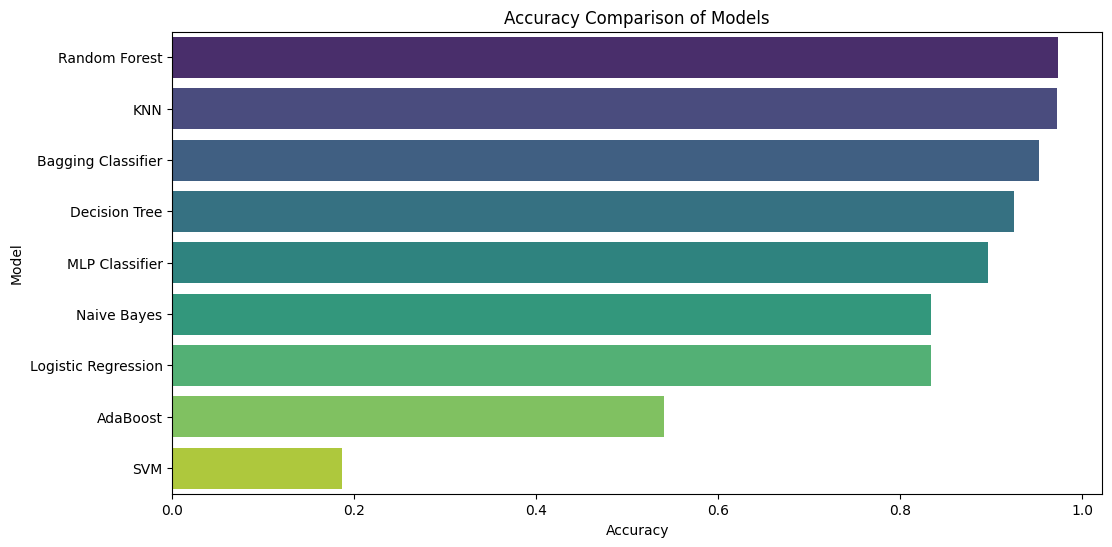

In [17]:
# Plot the model accuracy results
plt.figure(figsize=(12, 6))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Accuracy Comparison of Models")
plt.show()

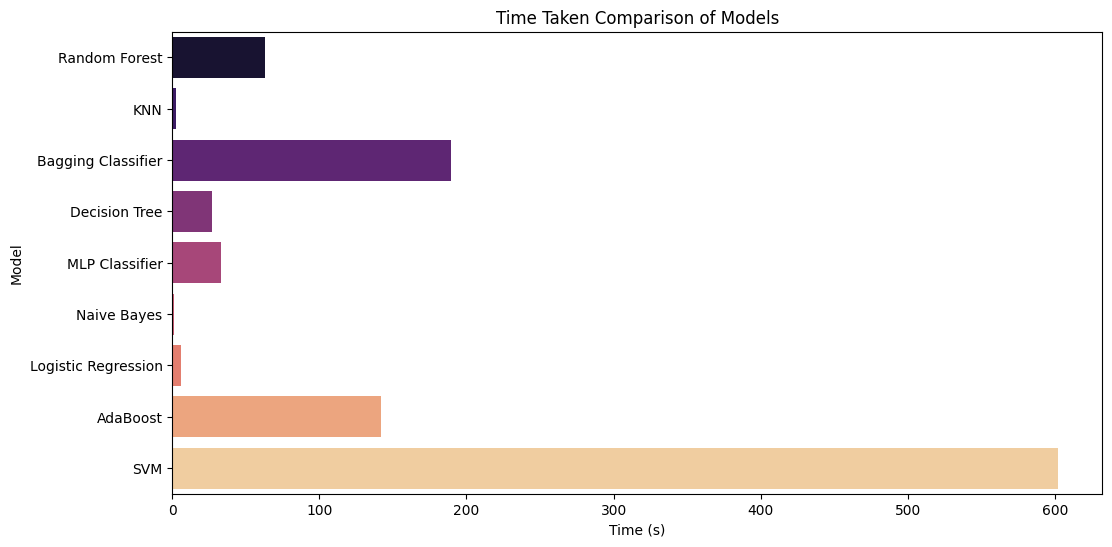

In [19]:
# Plot the time comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Time (s)", y="Model", data=results_df, palette="magma")
plt.title("Time Taken Comparison of Models")
plt.show()

# Hyperparameter Tuning

In [20]:
# Hyperparameter tuning for RandomForestClassifier using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [21]:
# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

Best parameters found: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.9746


In [22]:
# Evaluating on the test set
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy after tuning: {accuracy_rf:.4f}")

Random Forest Test Accuracy after tuning: 0.9767


# confusion Matrix and Classification Report for Best Model

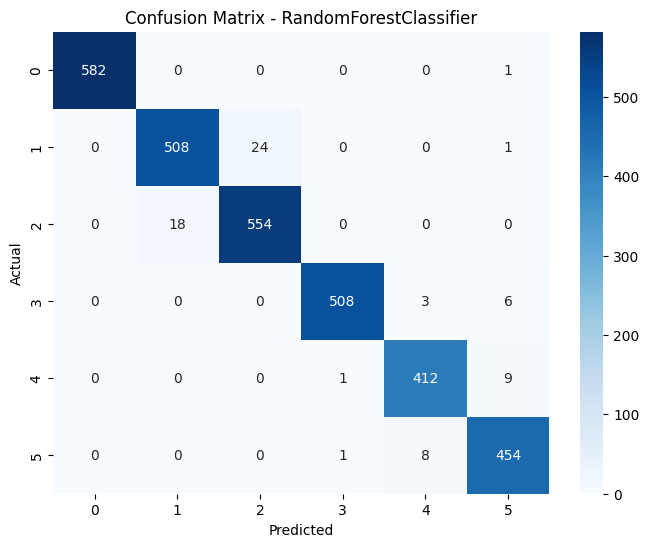

In [26]:
# Generate the confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report - RandomForestClassifier (After Tuning):")
print(report_rf)

Classification Report - RandomForestClassifier (After Tuning):
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       583
           SITTING       0.97      0.95      0.96       533
          STANDING       0.96      0.97      0.96       572
           WALKING       1.00      0.98      0.99       517
WALKING_DOWNSTAIRS       0.97      0.98      0.98       422
  WALKING_UPSTAIRS       0.96      0.98      0.97       463

          accuracy                           0.98      3090
         macro avg       0.98      0.98      0.98      3090
      weighted avg       0.98      0.98      0.98      3090



# Save the best RandomForest model to a file

In [30]:
import joblib
model_filename = 'Human activity_classification_model.pkl'
joblib.dump(best_rf, model_filename)

print(f"Model saved as {model_filename}")


Model saved as Human activity_classification_model.pkl


## Conclusion

In this project I use multiple model technique comparing models in order to come to the conclusion of the best fit model for this project such as LogisticRegression(),
     RandomForestClassifier(), SVC(), DecisionTreeClassifier(), KNeighborsClassifier(),GaussianNB(), LogisticRegression(), AdaBoostClassifier(),  BaggingClassifier(), MLPClassifier().
     
      RandomForest model is the best model with 97.6% accuracy,  making it the best-performing model among those evaluated. 

So, this is how you can train and compare multiple Machine
Learning models using Python. By comparing multiple models, we
aim to select the most effective algorithm that offers the optimal
balance of accuracy, complexity, and performance for their
specific problem.
